# Andrew's EDA notebook

# todo list
- filter out ûï@mention and http url links and \x89

In [318]:
import pandas as pd
import numpy as np
import random

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import re
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context = 'notebook', style = 'whitegrid')
ppt_colors = ['#4285f4', '#4e8df5', '#5b95f5', '#5b95f5', '#5b95f5', '#81aef7', '#81aef7', '#81aef7', '#81aef7', '#c3d8fb']

In [2]:
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
df.columns = ['text', 'target', 'emotion']

df = df[df['emotion'] != 'I can\'t tell']
df['target'].replace(['iPad', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'], 'Apple', inplace = True)
df['target'].replace(['Other Google product or service'], 'Google', inplace = True)
df['target'].replace(['Android App'], 'Android', inplace = True)

df['target'].fillna('No Target', inplace = True)
df.dropna(inplace = True)

# Initial EDA

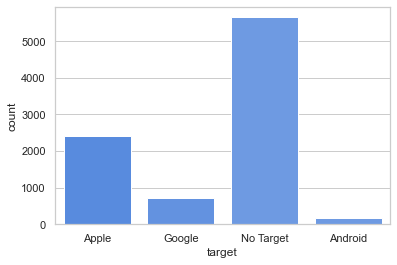

In [272]:
# target breakdown

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1)

ax = sns.countplot(x = 'target', data = df, palette = ppt_colors)

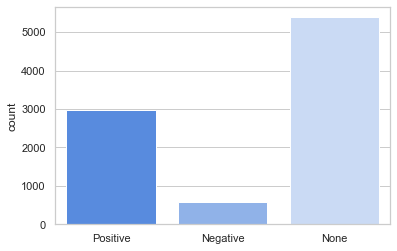

In [274]:
# emotion breakdown

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1)

ax = sns.countplot(x = 'emotion', data = df, palette = [ppt_colors[0], ppt_colors[5], ppt_colors[-1]], order = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product'])
ax.set(xlabel = '', xticklabels = ['Positive', 'Negative', 'None'])
plt.show()

In [5]:
# emotion breakdown by target

df.groupby(['target', 'emotion']).count()

text
target    emotion                                 
Android   Negative emotion                      16
          No emotion toward brand or product     2
          Positive emotion                     141
Apple     Negative emotion                     388
          No emotion toward brand or product    65
          Positive emotion                    1949
Google    Negative emotion                     115
          No emotion toward brand or product    24
          Positive emotion                     582
No Target Negative emotion                      51
          No emotion toward brand or product  5297
          Positive emotion                     306

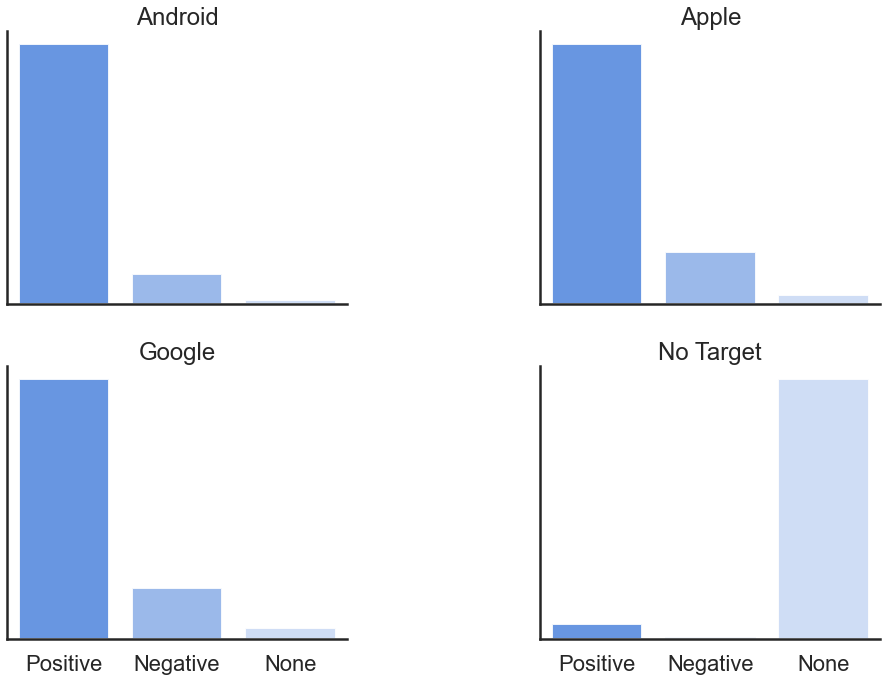

In [376]:
# emotion breakdown by target but fancier

sns.set(context = 'poster', style = 'white', font_scale = 1)
xlabel = ''
ylabel = ''
xticks = ['Positive', 'Negative', 'None']
yticks = ''
order = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product']
col_order = ['Android','Apple', 'Google', 'No Target']

ax = sns.catplot(data = df, x = 'emotion', col = 'target', kind = 'count', palette = [ppt_colors[0], ppt_colors[5], ppt_colors[-1]], order = order, col_order = col_order, col_wrap = 2, sharey = False, height = 5, aspect = 1.5, alpha = 0.9)
ax.set(xlabel = xlabel, ylabel = ylabel, xticklabels = xticks, yticklabels = yticks, title = 'Tweet Emotion per Target')
ax.despine(left = False)
ax.set_titles('{col_name}')
plt.savefig('../../reports/figures/emotion_target_breakdown_base.png', dpi = 500, bbox_inches = 'tight', transparent = True)
plt.show()

# Text Cleaning

In [197]:
sw = stopwords.words('english')
sw.extend(['link', 'rt', 'sxsw', 'get', 'google', 'apple', 'iphone', 'ipad'])
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!'
twitter_re = re.compile('[#@][a-zA-Z]*')
num_re = re.compile('^\d{1}$')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def txt_clean(txt, stop_words=sw):
    # takes in a string and returns a cleaned up string ready for count or tfidf vectorizing
    
    # splitting the text up into words
    t = txt.split(' ')
    # turning the words lowercase
    t = [w.lower() for w in t]
    # removing punctuation
    t = [w.translate(w.maketrans('','', punctuation)) for w in t]
    # removing @'s and #'s which are twitter jargon
    t = [w for w in t if not twitter_re.match(w)]
    # removing leftover numbers
    t = [w for w in t if not num_re.match(w)]
    # removing stop words and more twitter jargon
    t = [w for w in t if w not in stop_words]
    # removing empty strings
    t = [w for w in t if w]
    # word lemmatizing
    t = pos_tag(t)
    t = [(w[0], get_wordnet_pos(w[1])) for w in t]
    lem = WordNetLemmatizer()
    t = [lem.lemmatize(w[0], w[1]) for w in t]
    # joining all the strings together into one
    return ' '.join(t)

df['txt_cleaned'] = df['text'].map(txt_clean)

# Unigrams

In [346]:
# create a count vectorized dataset for unigrams

cv = CountVectorizer(ngram_range = (1,1))
X_count = cv.fit_transform(X)
X_count  = pd.DataFrame.sparse.from_spmatrix(X_count)
X_count.columns = sorted(cv.vocabulary_)
X_count.set_index(y.index, inplace=True)

every = X_count.sum().sort_values(ascending = False)[0:10]
positive = X_count[df['emotion'] == 'Positive emotion'].sum().sort_values(ascending = False)[0:10]
negative = X_count[df['emotion'] == 'Negative emotion'].sum().sort_values(ascending = False)[0:10]
no = X_count[df['emotion'] == 'No emotion toward brand or product'].sum().sort_values(ascending = False)[0:10]

In [288]:
# function that plots the top ten unigrams
# takes in sentiment which is whether we are looking for all tweets, positive tweets, negative tweets, or no emotion tweets
# takes in a title for the plot
# takes in a filename, if no filename is given, it won't save the plot
# returns a barplot of the top ten counted unigrams, as well as a png file if a filename is given

def sentiment_unigram_plot(sentiment, title, filename = None):
    plt.figure(figsize = (10,10))
    sns.set(context = 'poster', style = 'white', font_scale = 1)
    xlabel = ''
    ylabel = ''
    xticks = ''
    yticks = [ x.capitalize() for x in sentiment.keys()]


    ax = sns.barplot(x = sentiment.values, y = sentiment.keys(), orient = 'h', palette = ppt_colors, alpha = 0.9)
    ax.set(xlabel = xlabel, ylabel = ylabel, xticklabels = xticks, yticklabels = yticks, title = title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    sns.despine(top = True, bottom = True, left = False, right = True)
    if filename:
        plt.savefig(f'../../reports/figures/{filename}.png', dpi = 500, bbox_inches = 'tight', transparent = True)
    plt.show()

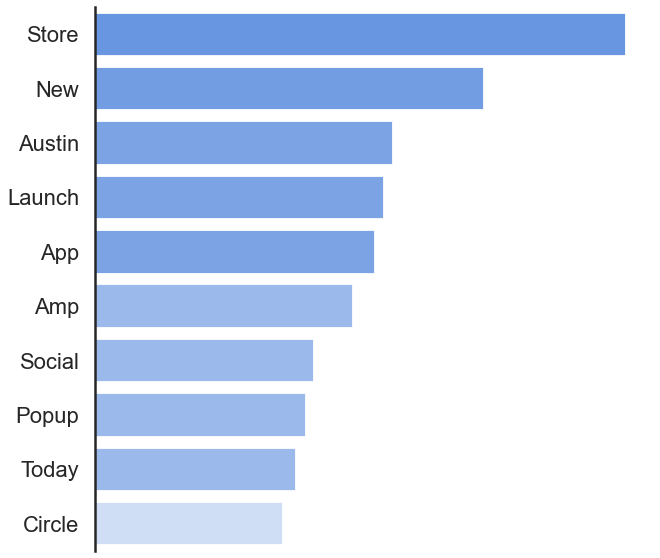

In [351]:
sentiment_unigram_plot(every, '', 'all_unigrams')

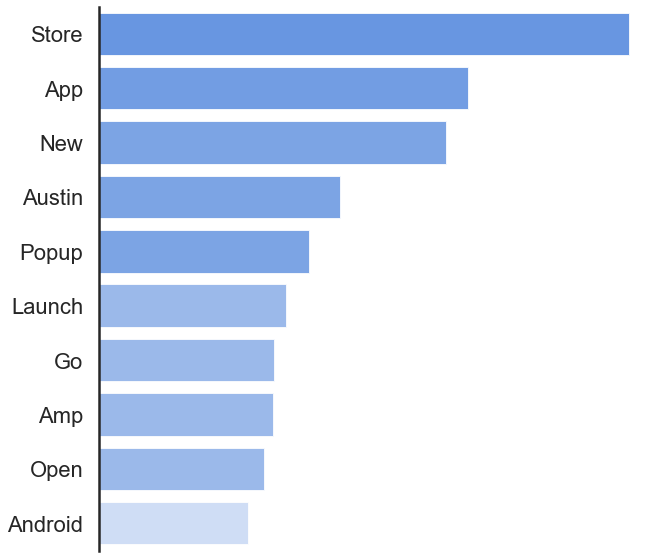

In [352]:
sentiment_unigram_plot(positive, '', 'positive_unigrams')

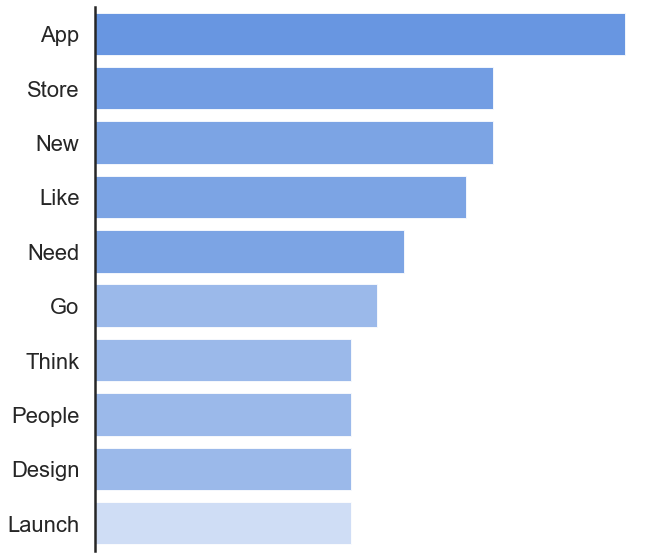

In [353]:
sentiment_unigram_plot(negative, '', 'negative_unigrams')

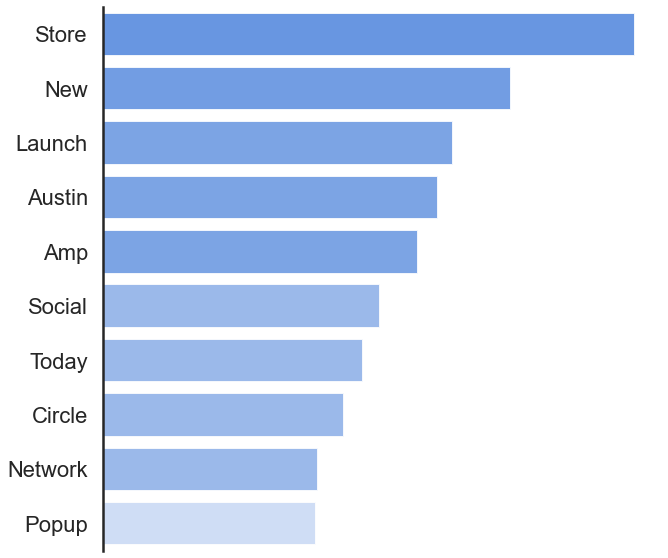

In [354]:
sentiment_unigram_plot(no, '', 'non_unigrams')

# Bigrams

In [355]:
# function that plots the top ten bigrams
# takes in sentiment which is whether we are looking for all tweets, positive tweets, negative tweets, or no emotion tweets
# takes in a title for the plot
# takes in a filename, if no filename is given, it won't save the plot
# returns a barplot of the top ten counted bigrams, as well as a png file if a filename is given

cv = CountVectorizer(ngram_range = (2,2))
X_count = cv.fit_transform(X)
X_count  = pd.DataFrame.sparse.from_spmatrix(X_count)
X_count.columns = sorted(cv.vocabulary_)
X_count.set_index(y.index, inplace=True)

every = X_count.sum().sort_values(ascending = False)[0:10]
positive = X_count[df['emotion'] == 'Positive emotion'].sum().sort_values(ascending = False)[0:10]
negative = X_count[df['emotion'] == 'Negative emotion'].sum().sort_values(ascending = False)[0:10]
no = X_count[df['emotion'] == 'No emotion toward brand or product'].sum().sort_values(ascending = False)[0:10]

In [366]:
def sentiment_bigram_plot(sentiment, title, filename = None):
    plt.figure(figsize = (20,10))
    sns.set(context = 'poster', style = 'white', font_scale = 1)
    xlabel = ''
    ylabel = ''
    xticks = ''
    yticks = [ x.title() for x in sentiment.keys()]


    ax = sns.barplot(x = sentiment.values, y = sentiment.keys(), orient = 'h', palette = ppt_colors, alpha = 0.9)
    ax.set(xlabel = xlabel, ylabel = ylabel, xticklabels = xticks, yticklabels = yticks, title = title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    sns.despine(top = True, bottom = True, left = False, right = True)
    if filename:
        plt.savefig(f'../../reports/figures/{filename}.png', dpi = 500, bbox_inches = 'tight', transparent = True)
    plt.show()

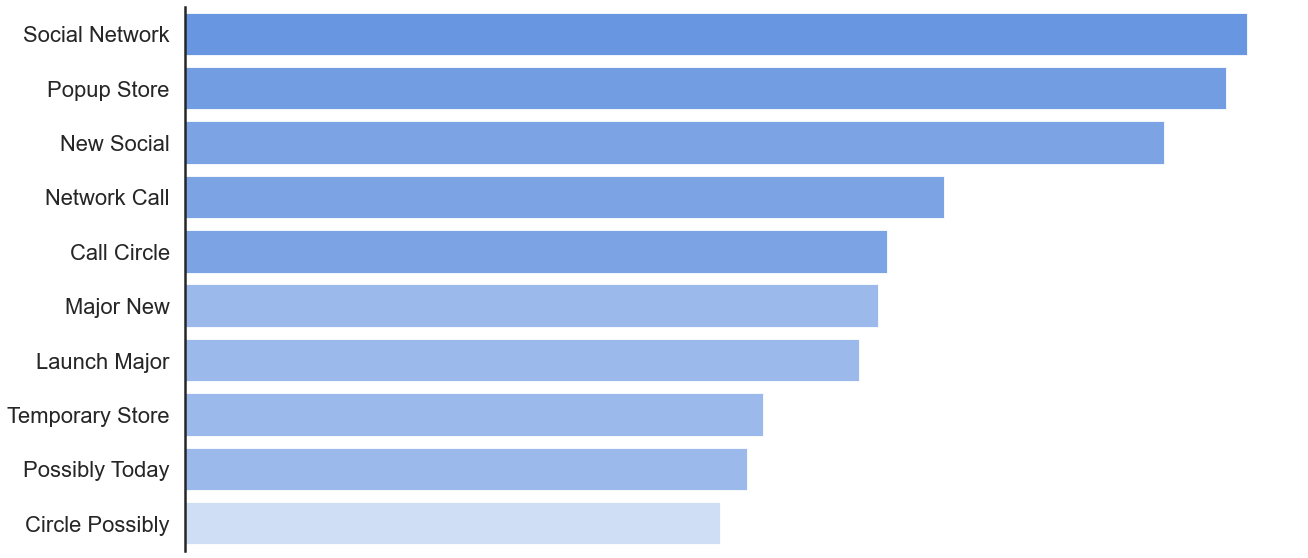

In [371]:
sentiment_bigram_plot(every, '', 'all_bigrams')

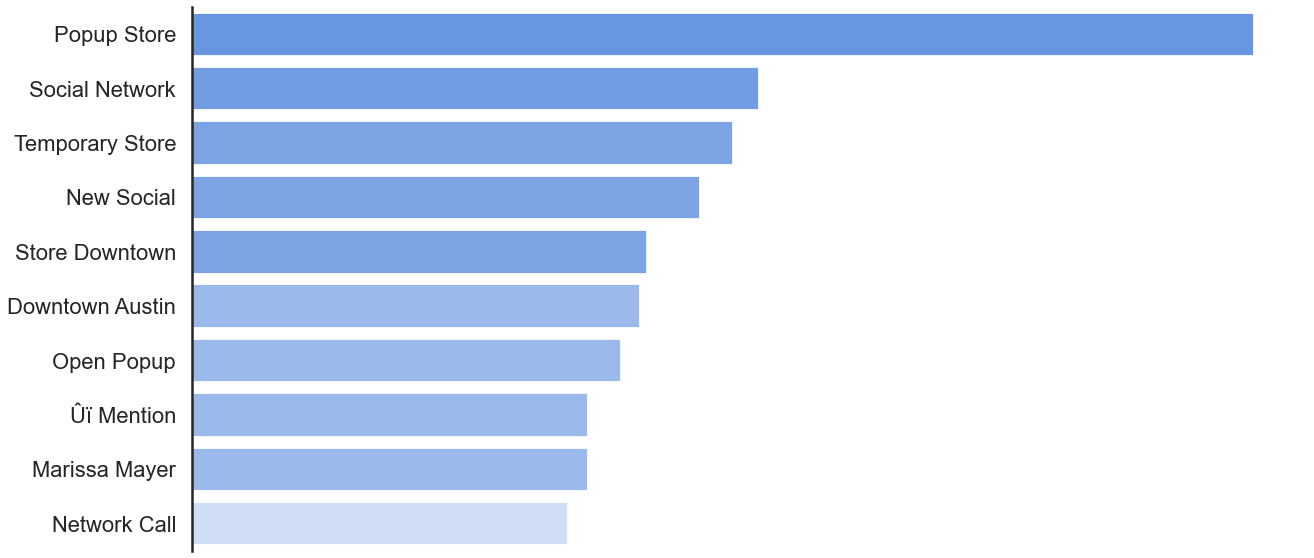

In [372]:
sentiment_bigram_plot(positive, '', 'positive_bigrams')

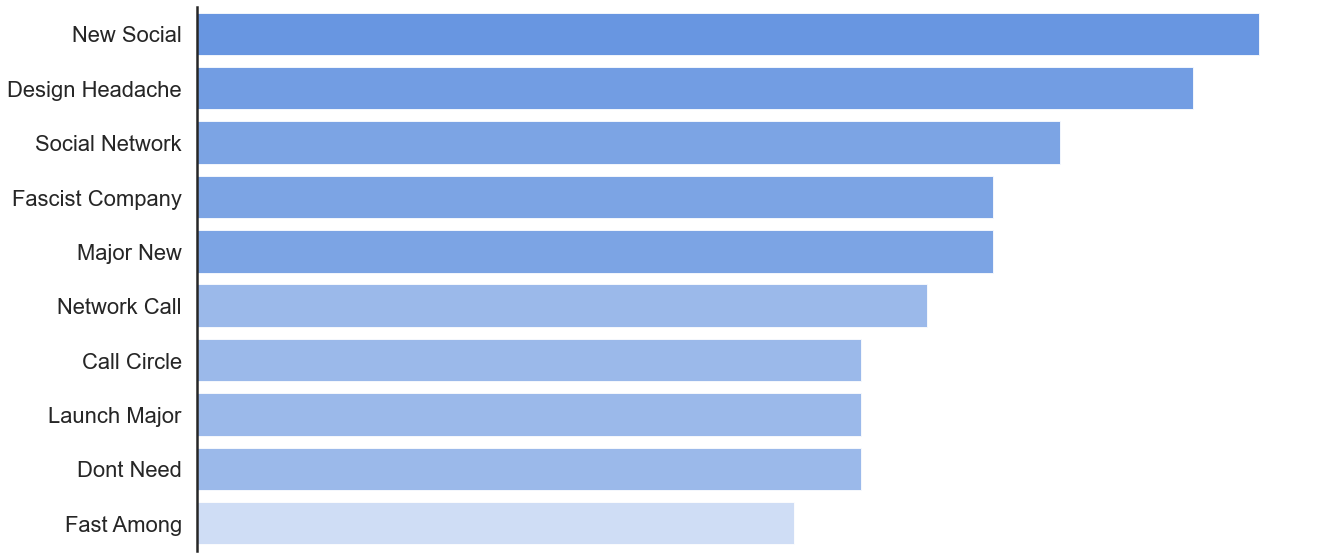

In [373]:
sentiment_bigram_plot(negative, '', 'negative_bigrams')

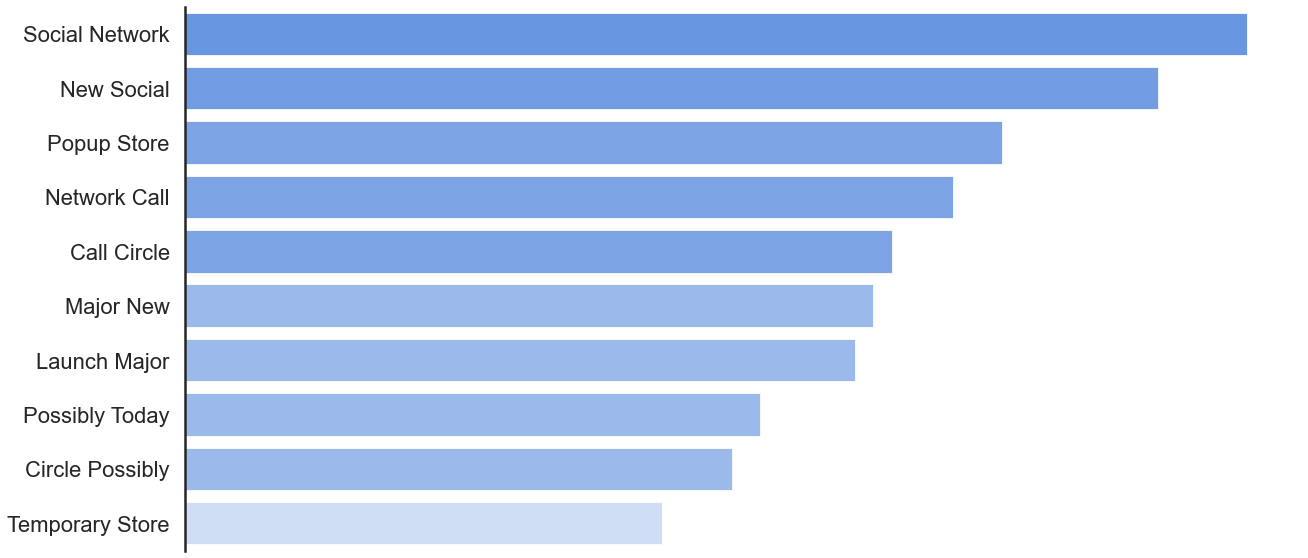

In [374]:
sentiment_bigram_plot(no, '', 'non_bigrams')

# Word Cloud

In [208]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

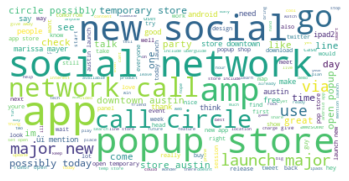

In [209]:
# basic wordcloud for the entire dataset; proof of concept
wordcloud = WordCloud(stopwords = ['apple', 'google', 'ipad', 'iphone', 'get'], max_font_size = 50, max_words = 1000, background_color = 'white').generate(df['txt_cleaned'].str.cat(sep = ' '))
fig = plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [229]:
# the wordcloud again but masked in the form of the twitter logo

# takes in an image of the logo and creates a mask of it
tweet_mask = np.array(Image.open('../../data/twitter_mask.png'))

# turns values of 0 into 255, which is pure white
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
# turns the mask array into one suitable for word clouds
transformed_tweet_mask = np.ndarray((tweet_mask.shape[0],tweet_mask.shape[1]), np.int32)
for i in range(len(tweet_mask)):
    transformed_tweet_mask[i] = list(map(transform_format, tweet_mask[i]))

In [375]:
# definition for plotting wordclouds with a twitter logo shape, and blue color scheme
# takes in sentiment which is whether we are looking for all tweets, positive tweets, negative tweets, or no emotion tweets
# also takes in filename to give a name to the plot when saved as an image
# returns a wordcloud plot as well as a png file if a filename is given

def wordcloud_plot(sentiment, filename = None):   
    
    # function for providing a color scheme that is centered around the color blue
    def blue_color_func(word, font_size, position, orientation, random_state=None,
                        **kwargs):
        return "hsl(203, 100%%, %d%%)" % random.randint(30, 80)
    
    # initializes the word cloud with preset parameters
    wc = WordCloud(width = 800, height = 400, scale = 5, max_words=1000, mask=transformed_tweet_mask,
                   stopwords=['apple', 'google', 'ipad', 'iphone', 'get'], 
                   mode = 'RGBA', background_color = None)
    
    # change data fed into the word cloud based on sentiment parameter
    if sentiment == 'all':
        wc.generate(df['txt_cleaned'].str.cat(sep = ' '))
    else:
        wc.generate(df[df['emotion'] == sentiment]['txt_cleaned'].str.cat(sep = ' '))

    # show the word cloud
    plt.figure(figsize=[100,50])
    plt.imshow(wc.recolor(color_func=blue_color_func, random_state=3), interpolation='bilinear')
    plt.axis("off")
    plt.show()


    # store to file
    if filename:
        wc.to_file(f"../../reports/figures/{filename}.png")

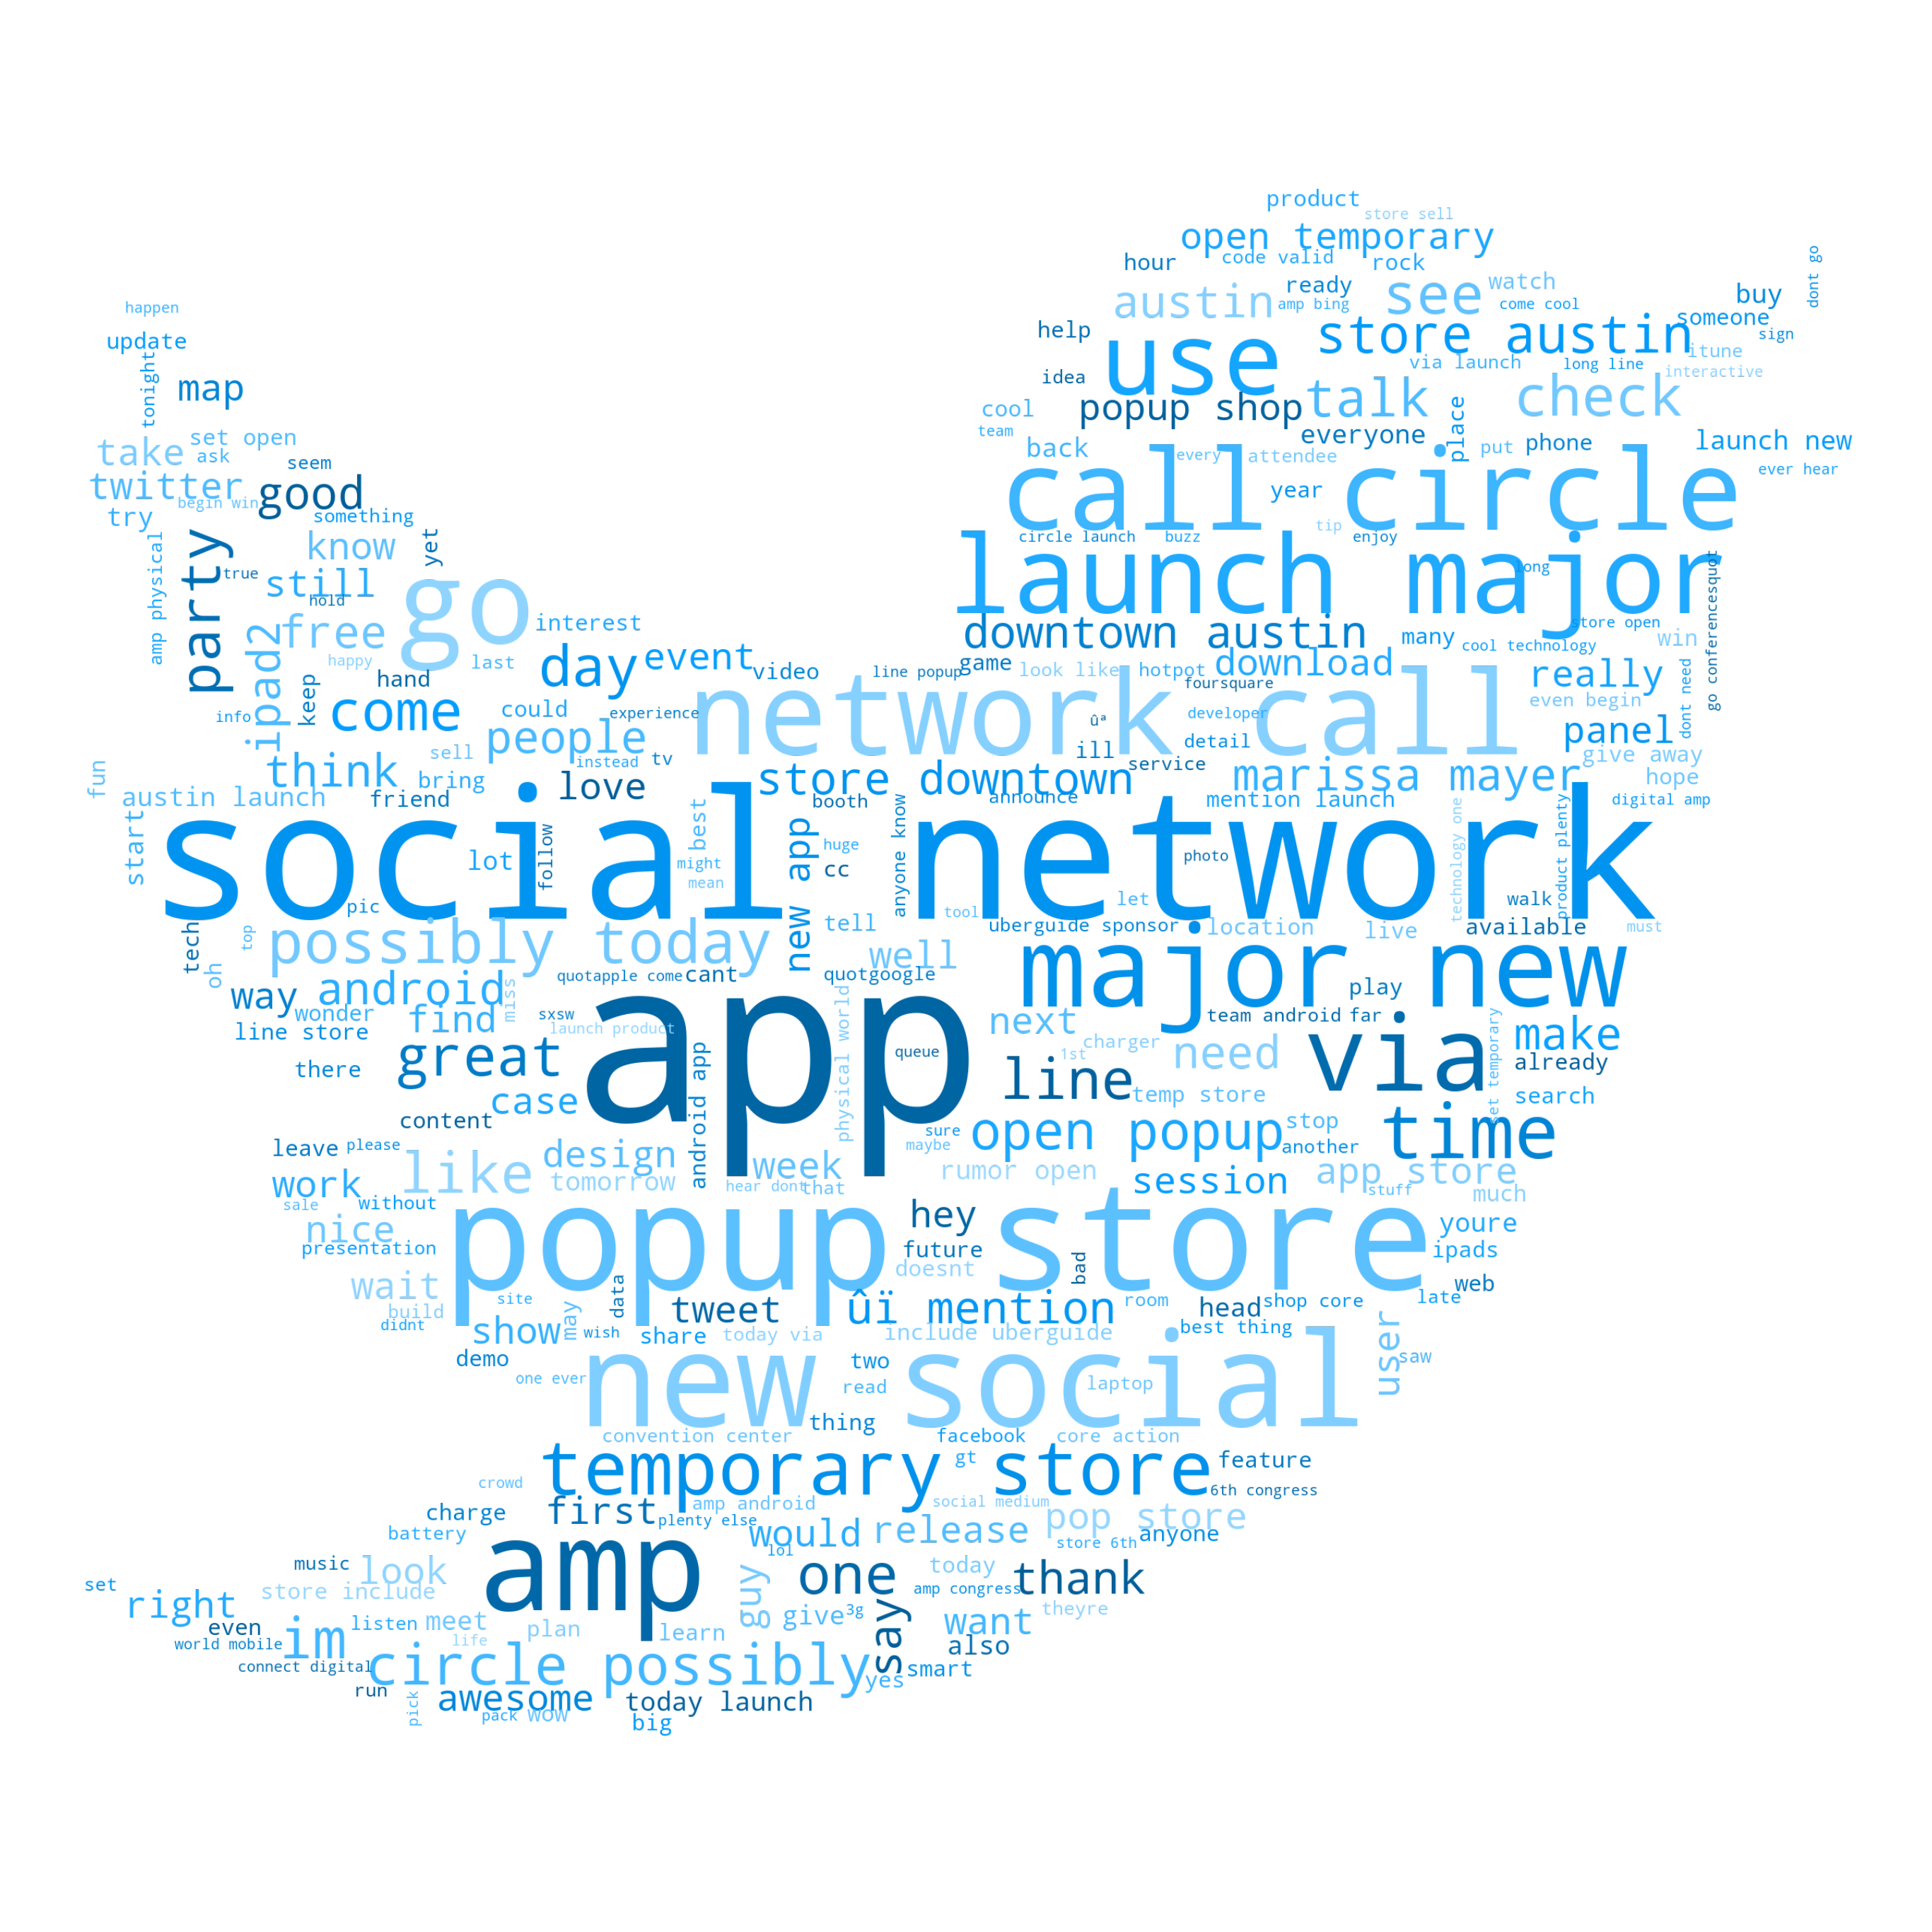

In [342]:
wordcloud_plot('all', 'all_wc')

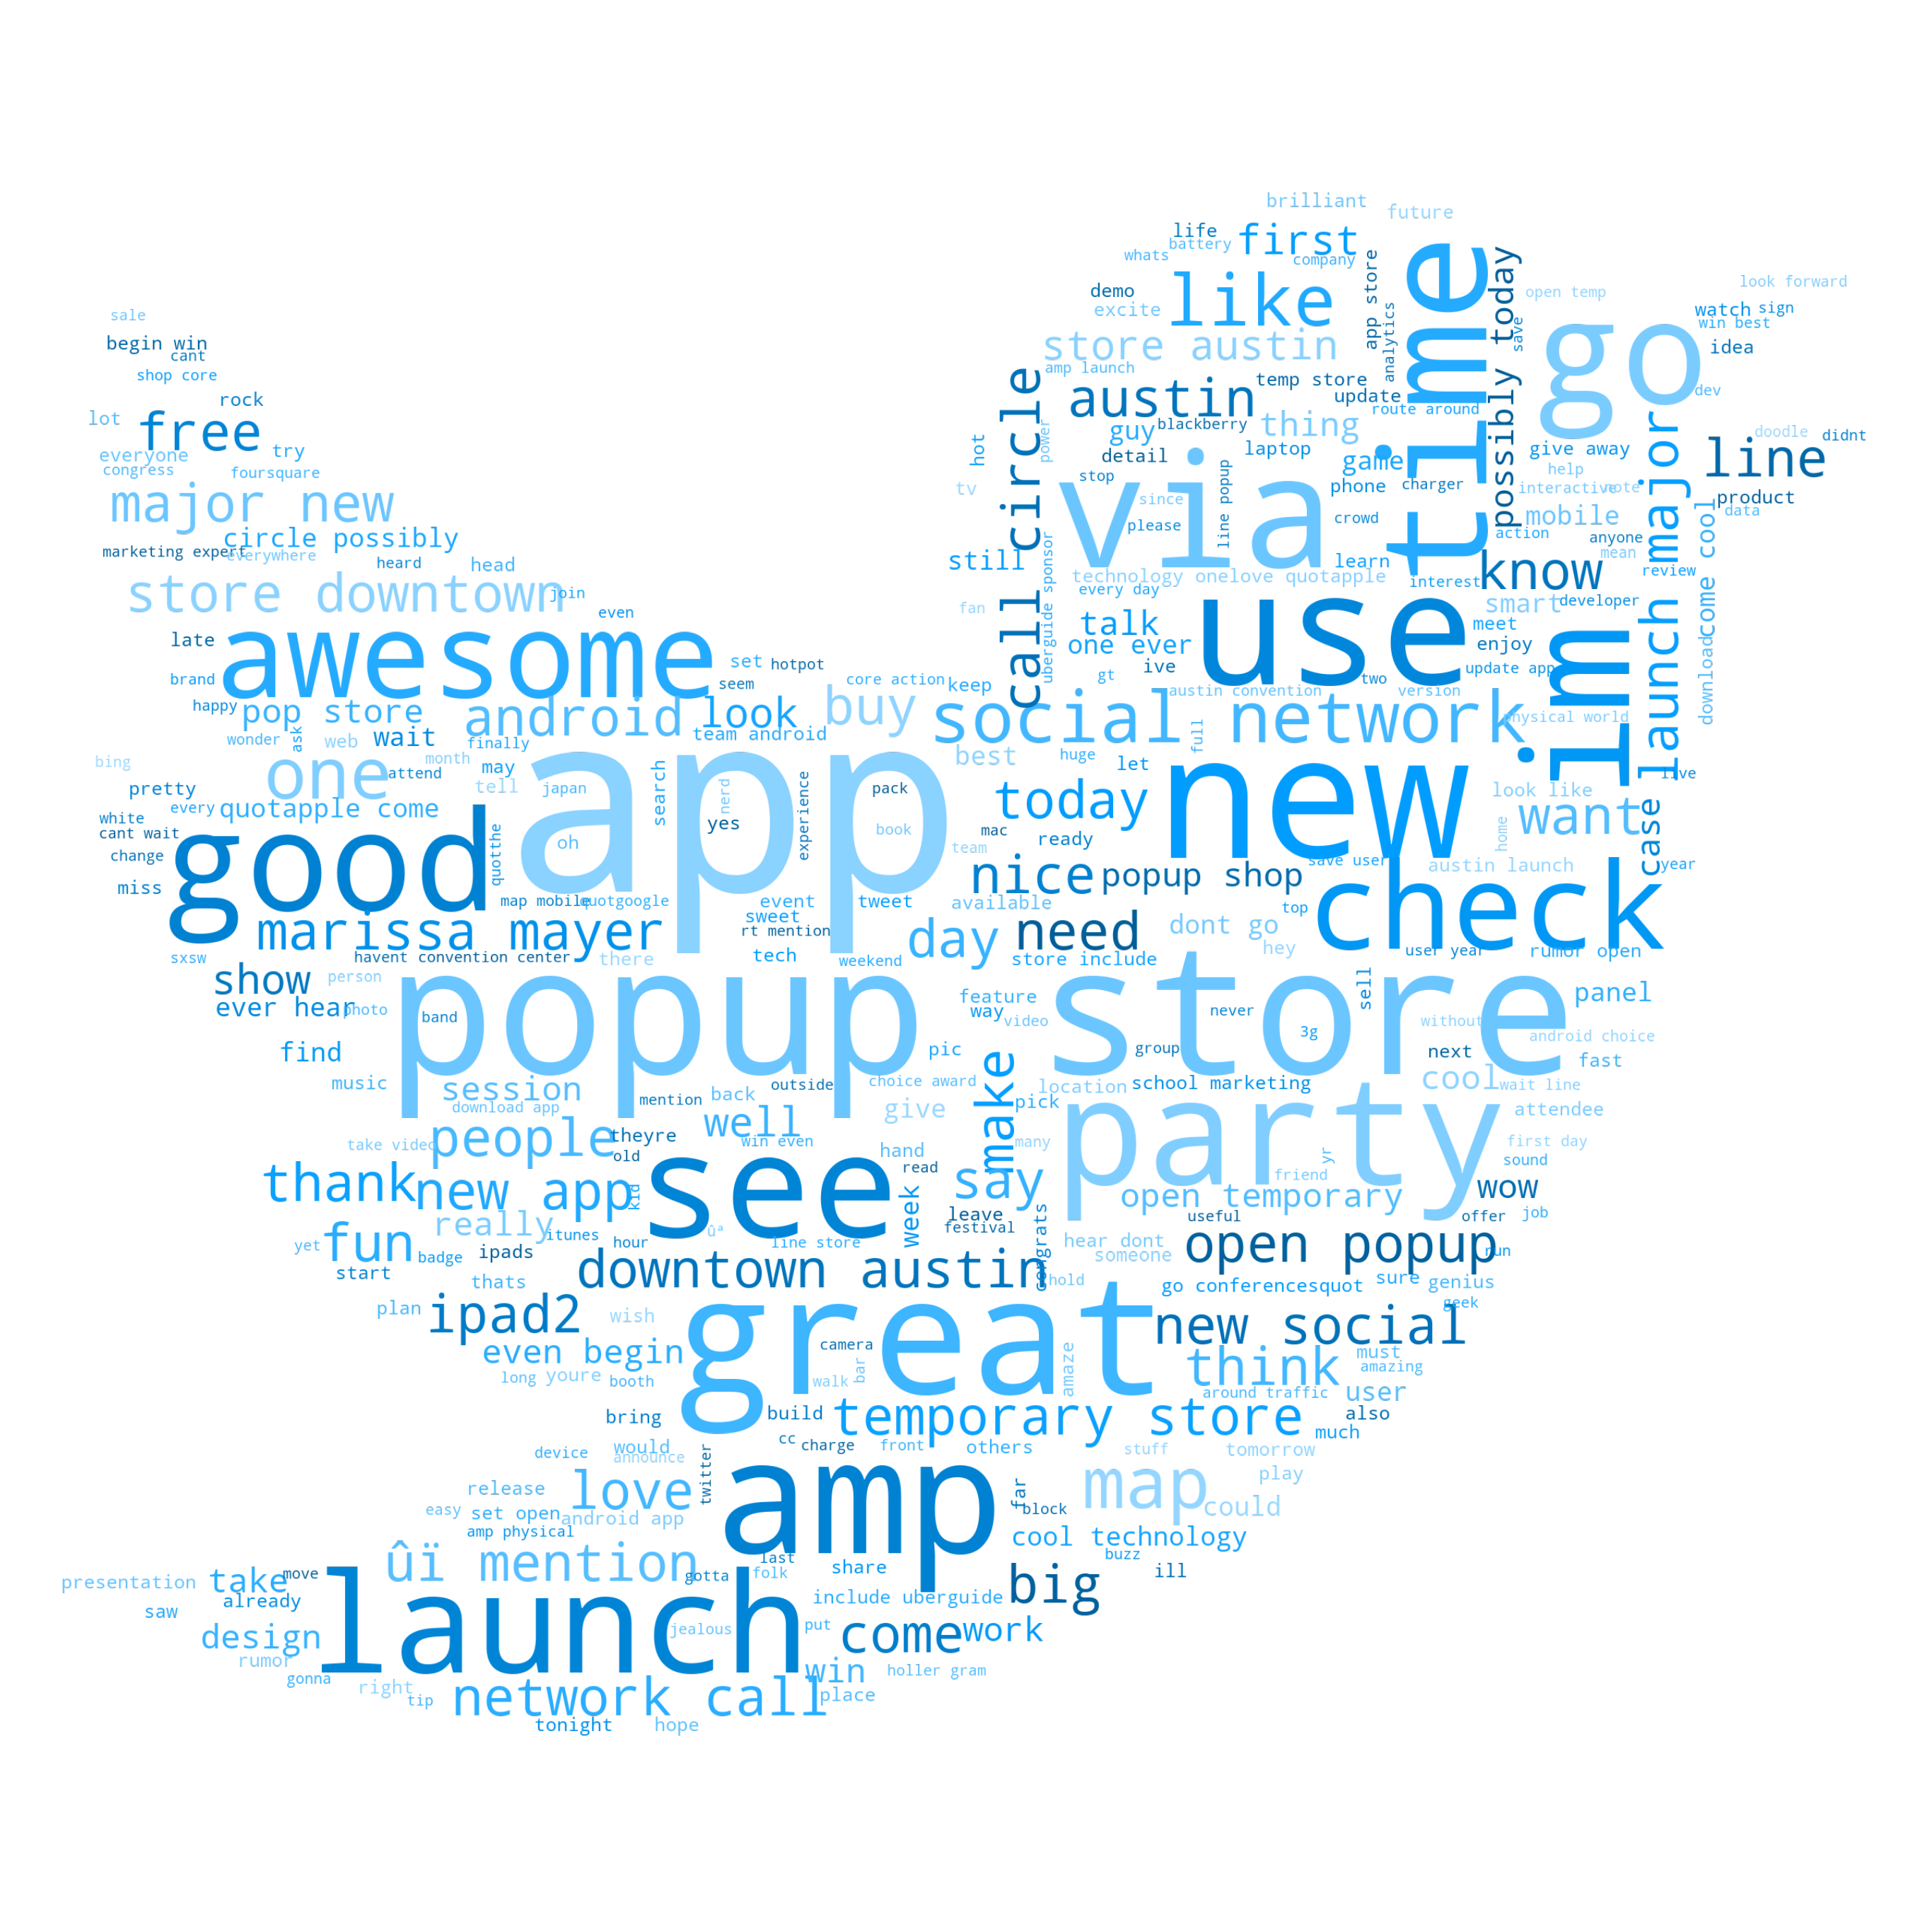

In [343]:
wordcloud_plot('Positive emotion', 'positive_wc')

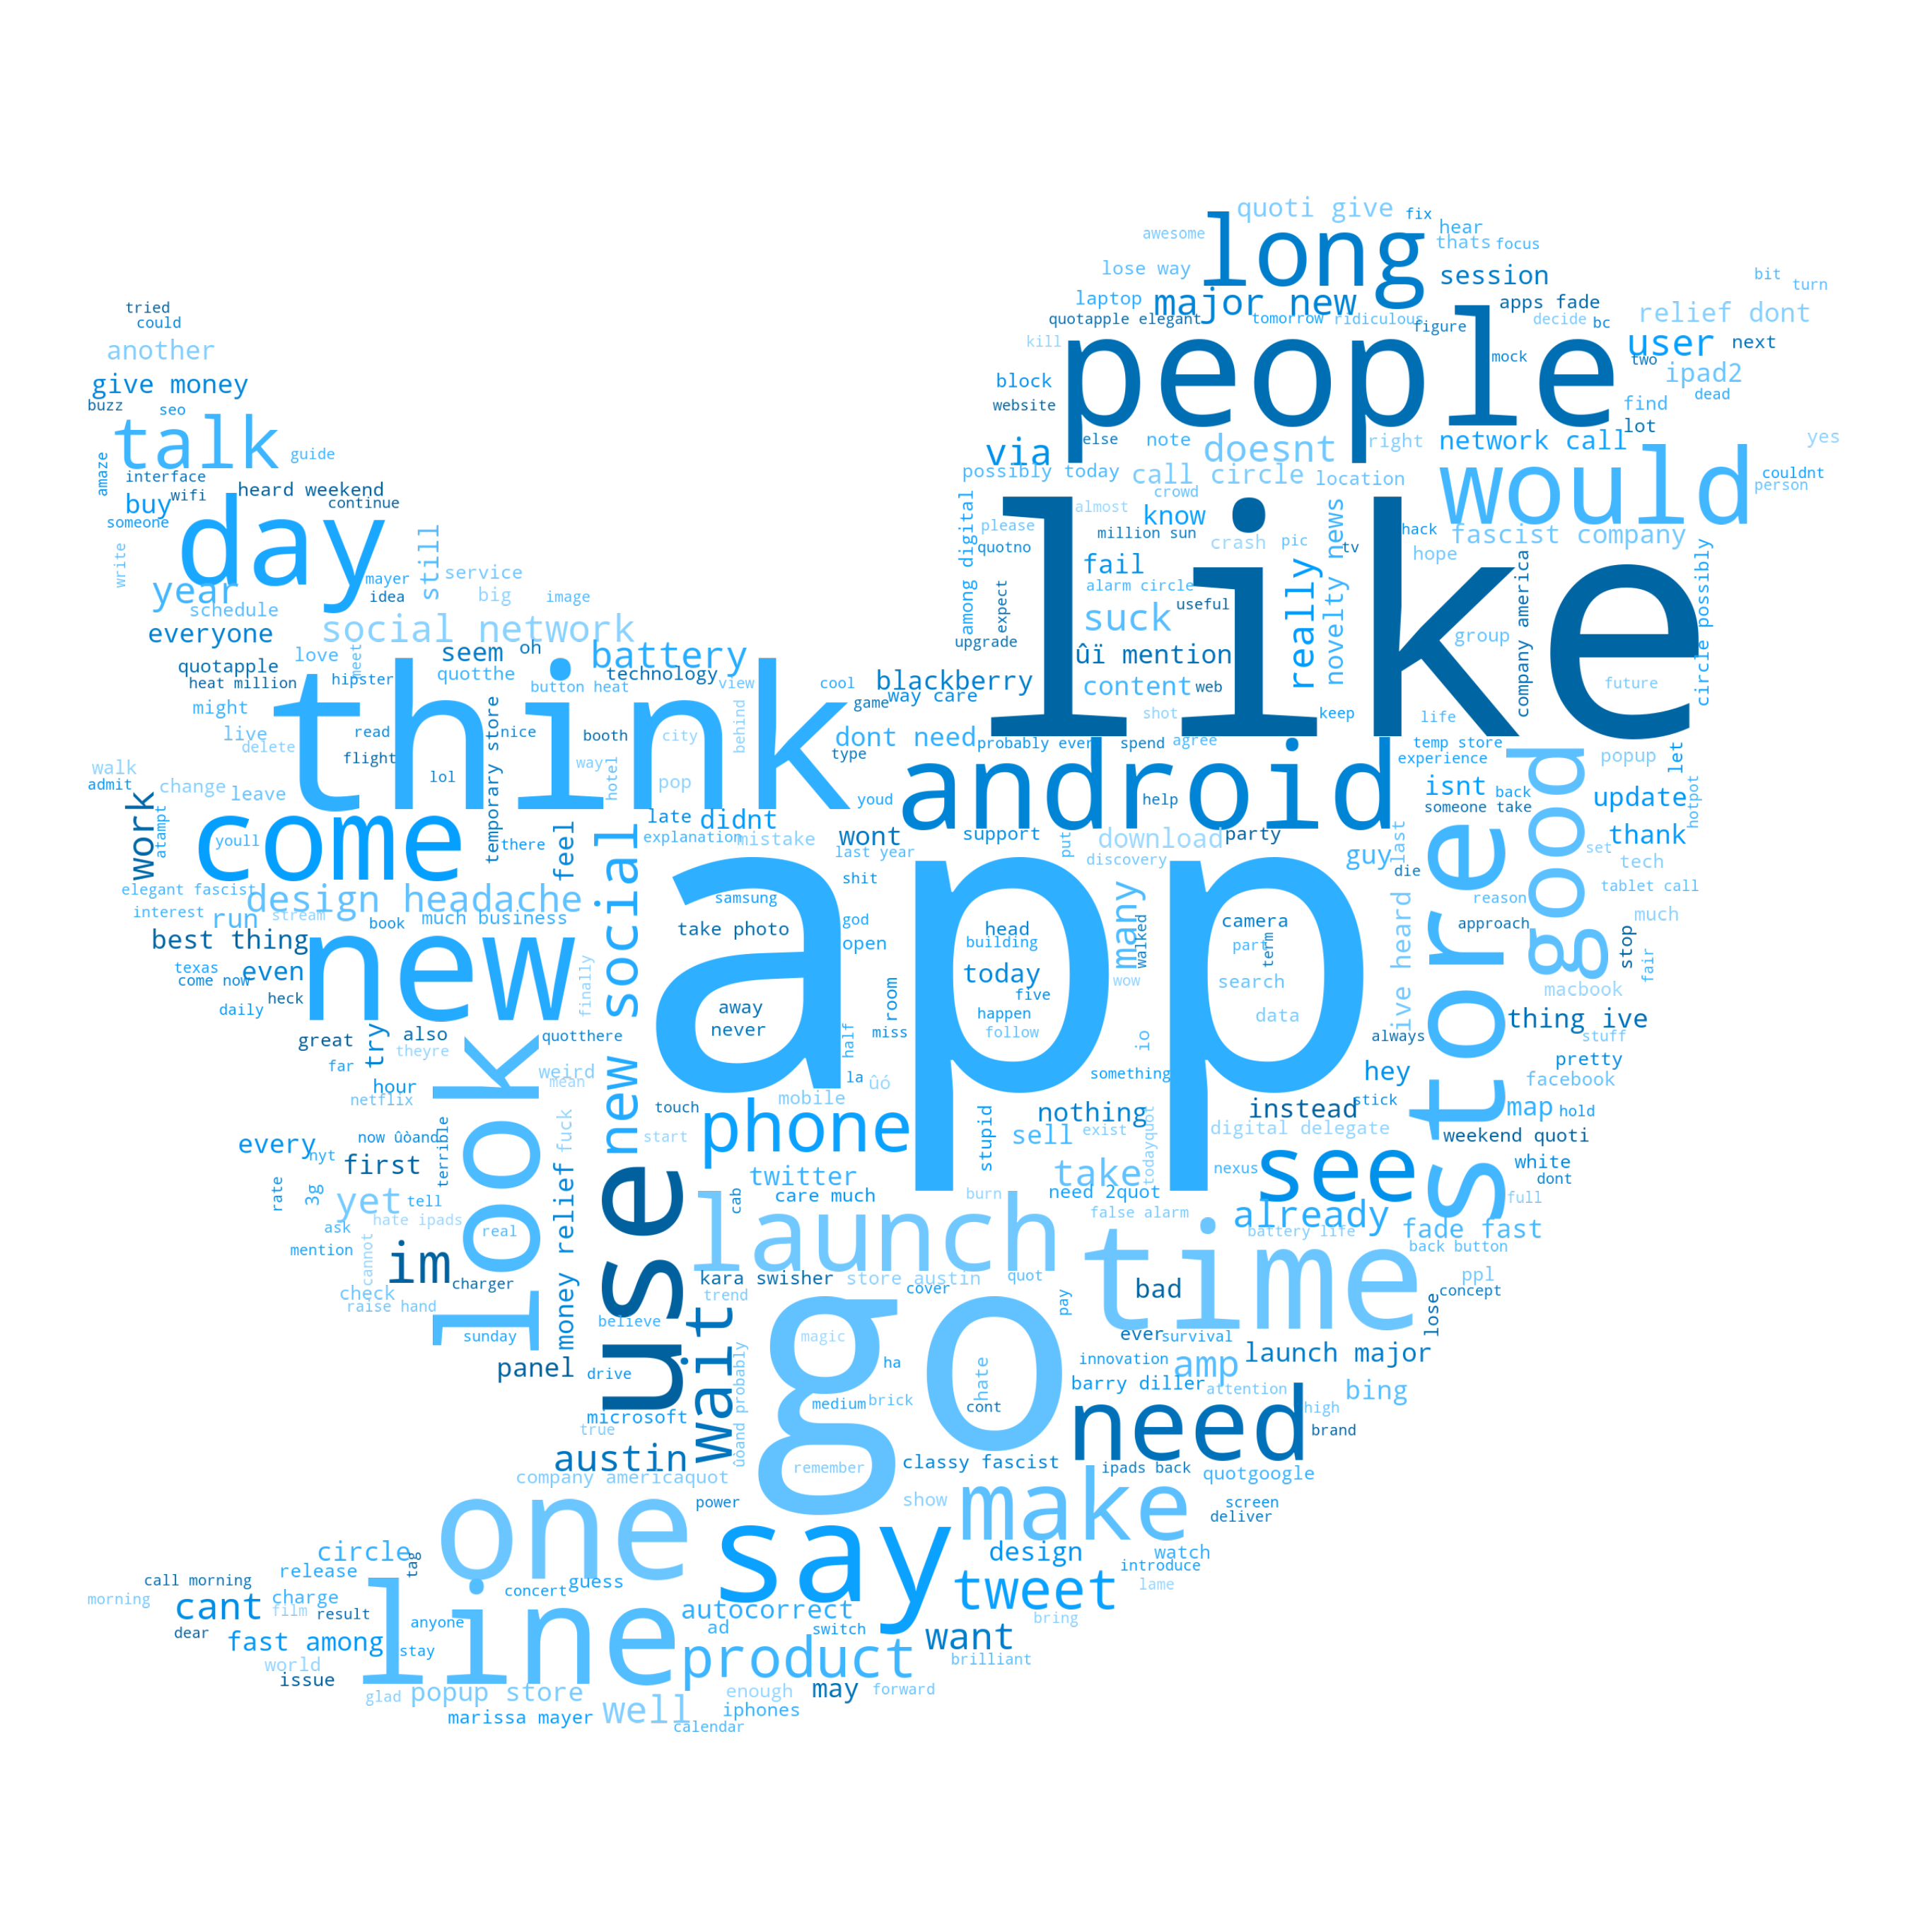

In [344]:
wordcloud_plot('Negative emotion', 'negative_wc')

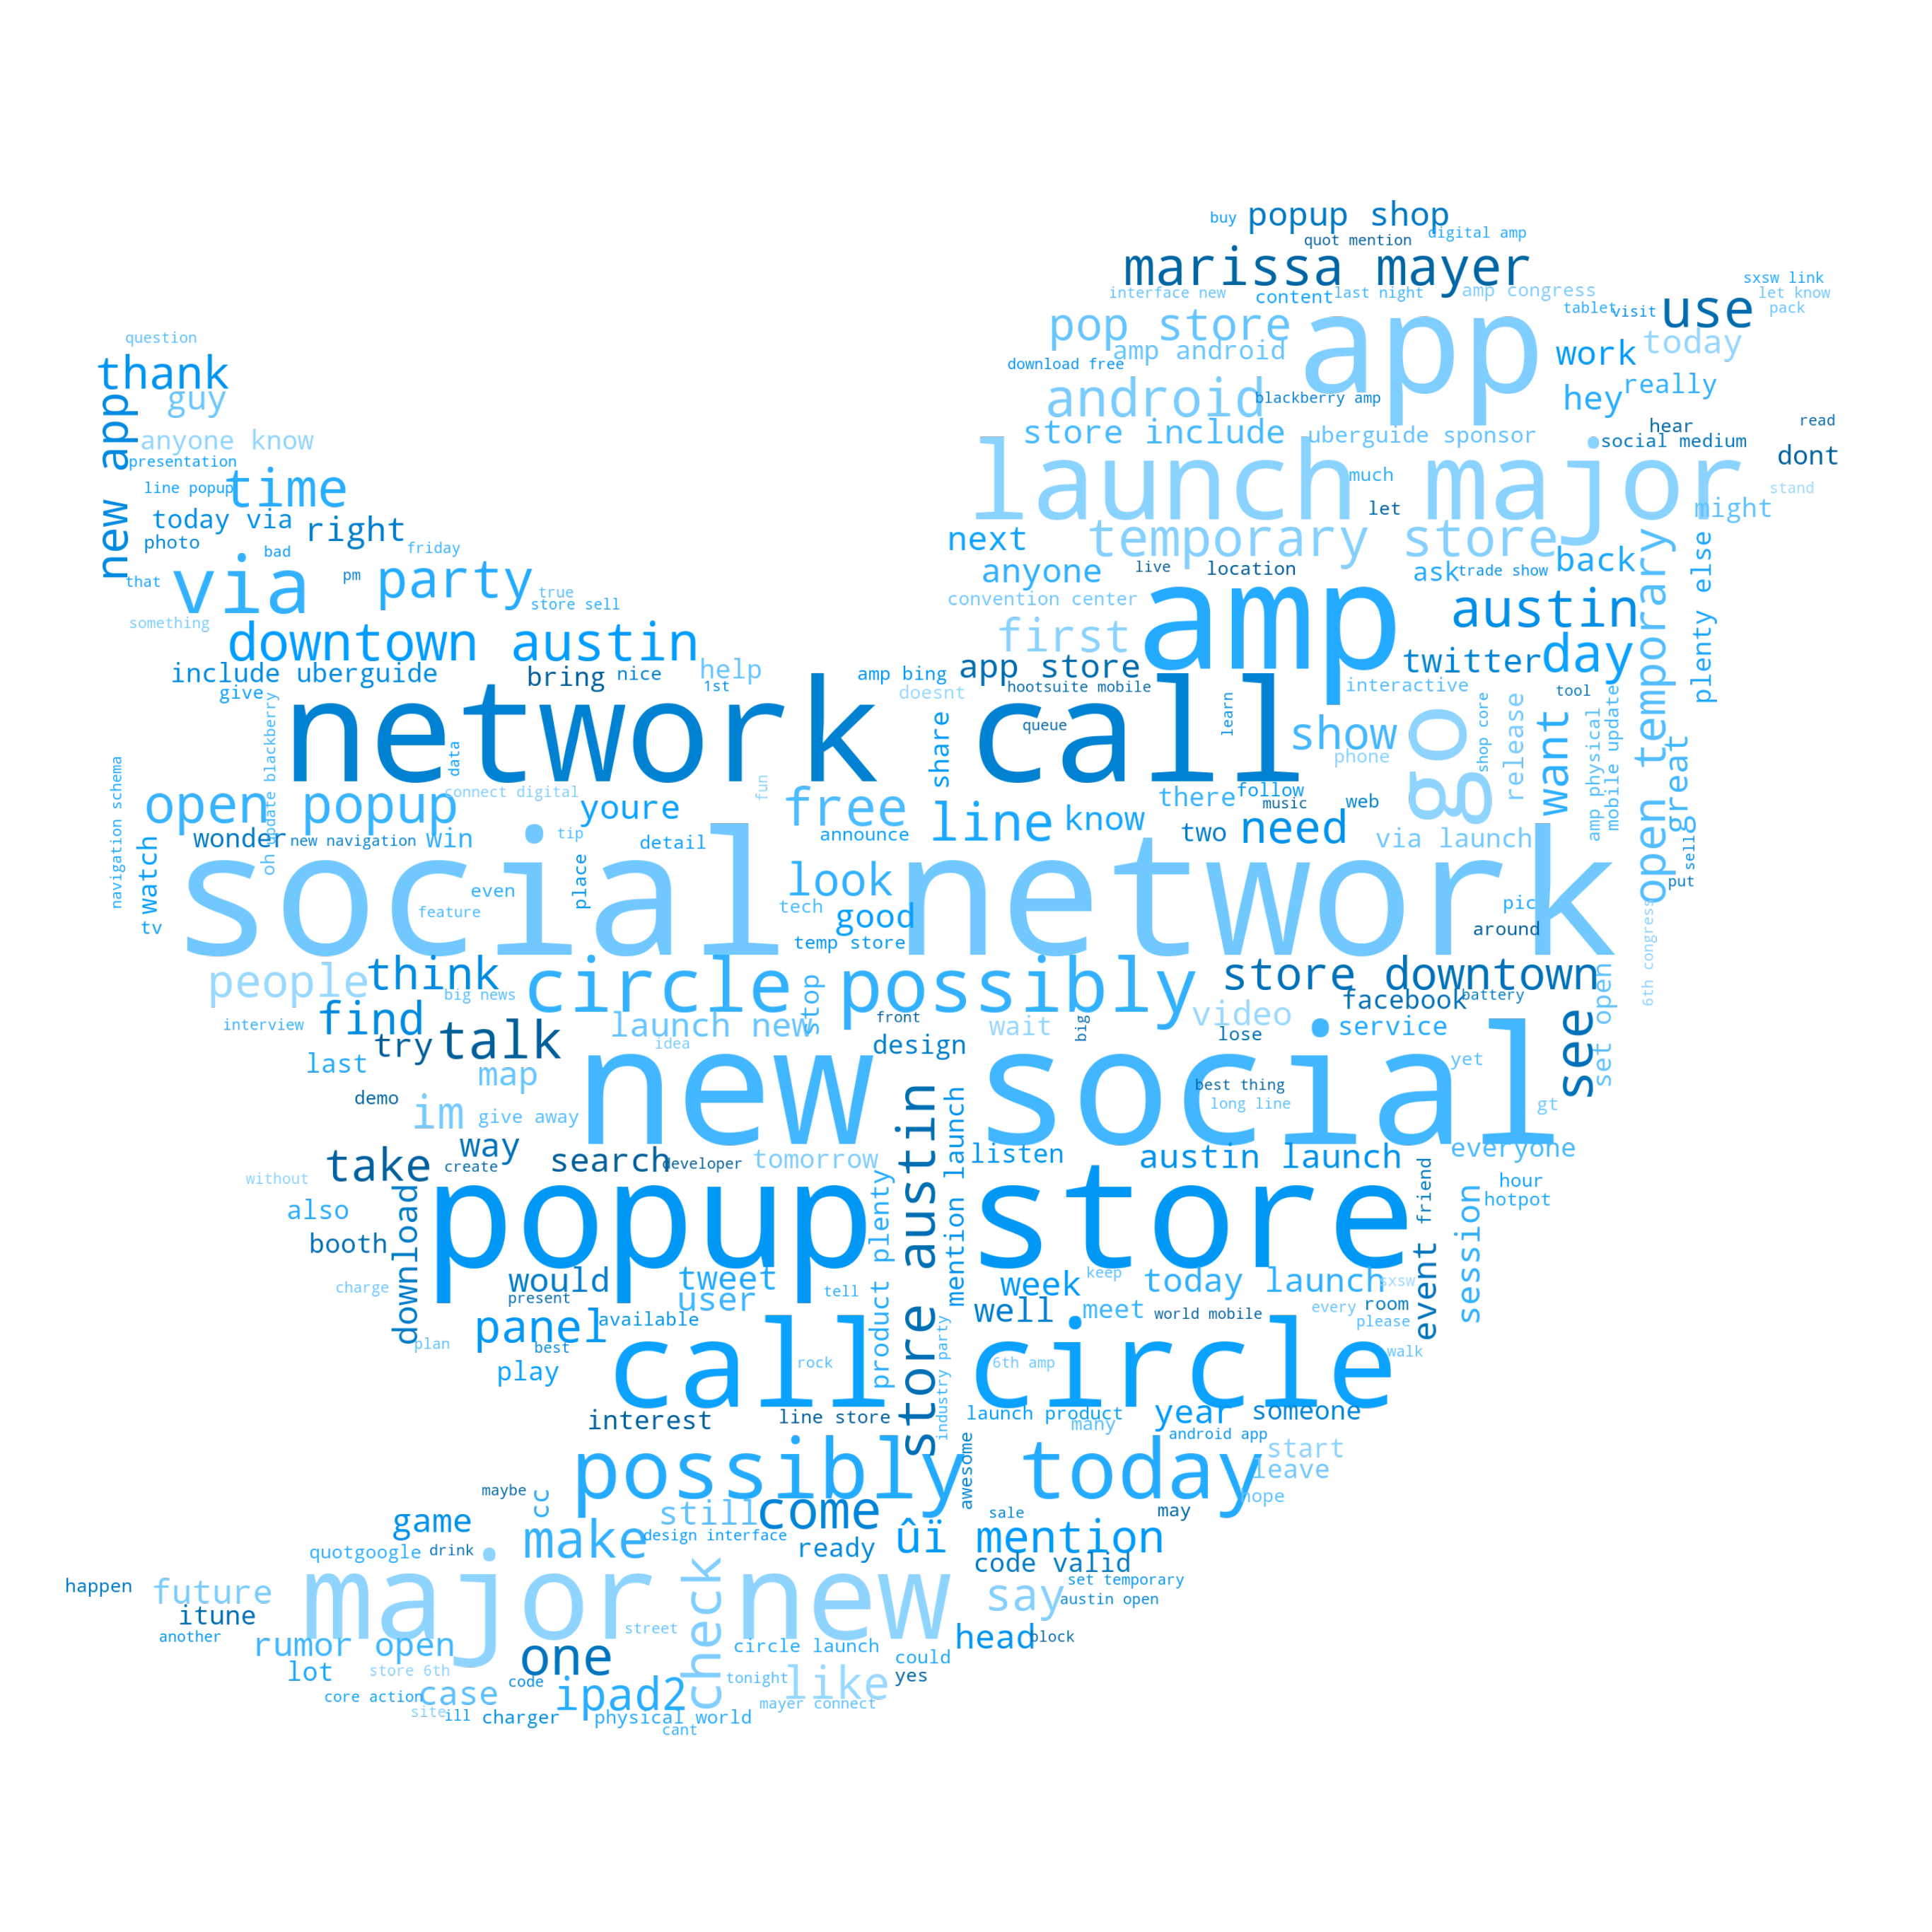

In [345]:
wordcloud_plot('No emotion toward brand or product', 'non_wc')

# Data Preprocessing 

In [198]:
# divides data into X and y, and then turns the model target labels into numerical format

X = df['txt_cleaned']
y = df['emotion'].replace(to_replace = {'Positive emotion' : 0, 'Negative emotion' : 1, 'No emotion toward brand or product': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X, y, random_state = 42, test_size = 0.25)

## Count Vectorizer

In [199]:
cv = CountVectorizer(ngram_range = (1,1))
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

store      1111
new         801
launch      615
austin      614
app         585
amp         550
social      469
popup       427
today       422
circle      397
open        361
network     352
go          352
line        328
via         323
android     322
dtype: int64

In [200]:
cv = CountVectorizer(ngram_range = (2,2))
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

social network     338
popup store        325
new social         308
network call       239
call circle        222
major new          220
launch major       213
temporary store    187
possibly today     179
circle possibly    170
downtown austin    138
ûï mention         134
marissa mayer      132
store downtown     132
store austin       130
open popup         121
dtype: int64

In [201]:
cv = CountVectorizer(ngram_range = (3,3))
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

new social network          288
social network call         238
major new social            219
network call circle         215
launch major new            213
call circle possibly        168
circle possibly today       168
store downtown austin       117
open temporary store        108
temporary store downtown     77
popup store austin           64
open popup store             63
open popup shop              56
downtown austin launch       55
launch new social            49
rumor open temporary         48
dtype: int64

## Tfidf Vectorizer

In [202]:
tfidf = TfidfVectorizer(ngram_range = (1,1))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace = True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

store      232.754934
new        164.683823
launch     151.630980
austin     139.152442
app        124.349935
social     121.266819
popup      117.843415
circle     114.139122
today      107.380222
open       107.017833
amp        104.570787
network    103.692296
via         90.282673
line        87.238168
call        85.940698
go          80.454228
dtype: float64

In [203]:
tfidf = TfidfVectorizer(ngram_range = (2,2))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace = True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.mean(axis = 0).sort_values(ascending = False)[:16]

social network     0.012871
new social         0.012075
popup store        0.011281
network call       0.010188
call circle        0.009623
major new          0.009447
launch major       0.009276
possibly today     0.008182
temporary store    0.008133
circle possibly    0.007913
store austin       0.006158
downtown austin    0.005948
open popup         0.005938
store downtown     0.005905
open temporary     0.005599
ûï mention         0.004758
dtype: float64

In [204]:
tfidf = TfidfVectorizer(ngram_range = (3,3))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace = True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

new social network          80.137694
social network call         69.935329
network call circle         65.313997
major new social            64.712864
launch major new            63.743781
call circle possibly        54.022252
circle possibly today       54.005559
open temporary store        38.100215
store downtown austin       36.312710
temporary store downtown    27.969892
popup store austin          24.687708
open popup store            24.318210
downtown austin launch      23.002409
open popup shop             21.364177
launch new social           20.361676
rumor open temporary        19.746143
dtype: float64

In [205]:
X_t_vec

02 symbian window  03 blackberry 02  0310 weve get  031111 cover social  \
3363                0.0               0.0            0.0                  0.0   
3204                0.0               0.0            0.0                  0.0   
4460                0.0               0.0            0.0                  0.0   
2311                0.0               0.0            0.0                  0.0   
6298                0.0               0.0            0.0                  0.0   
...                 ...               ...            ...                  ...   
5837                0.0               0.0            0.0                  0.0   
5285                0.0               0.0            0.0                  0.0   
5488                0.0               0.0            0.0                  0.0   
873                 0.0               0.0            0.0                  0.0   
7396                0.0               0.0            0.0                  0.0   

      0610 316 austin  10 app licence  10 app update  10 apps you  \
3363              0.0             0.0            0.0          0.0   
3204              0.0             0.0            0.0          0.0   
4460              0.0             0.0            0.0          0.0   
2311              0.0             0.0            0.0          0.0   
6298              0.0             0.0            0.0          0.0   
...               ...             ...            ...          ...   
5837              0.0             0.0            0.0          0.0   
5285              0.0             0.0            0.0          0.0   
5488              0.0             0.0            0.0          0.0   
873               0.0             0.0            0.0          0.0   
7396              0.0             0.0            0.0          0.0   

      10 attendee mac  10 austin airport  ...  ûó marissa mayer  ûó maybe via  \
3363              0.0                0.0  ...               0.0           0.0   
3204              0.0                0.0  ...               0.0           0.0   
4460              0.0                0.0  ...               0.0           0.0   
2311              0.0                0.0  ...               0.0           0.0   
6298              0.0                0.0  ...               0.0           0.0   
...               ...                ...  ...               ...           ...   
5837              0.0                0.0  ...               0.0           0.0   
5285              0.0                0.0  ...               0.0           0.0   
5488              0.0                0.0  ...               0.0           0.0   
873               0.0                0.0  ...               0.0           0.0   
7396              0.0                0.0  ...               0.0           0.0   

      ûó novelty news  ûó quotapple open  ûó stole little  ûó theft public  \
3363              0.0                0.0              0.0              0.0   
3204              0.0                0.0              0.0              0.0   
4460              0.0                0.0              0.0              0.0   
2311              0.0                0.0              0.0              0.0   
6298              0.0                0.0              0.0              0.0   
...               ...                ...              ...              ...   
5837              0.0                0.0              0.0              0.0   
5285              0.0                0.0              0.0              0.0   
5488              0.0                0.0              0.0              0.0   
873               0.0                0.0              0.0              0.0   
7396              0.0                0.0              0.0              0.0   

      ûócan tell white  ûólewis carroll crowd  ûómy almost power  \
3363               0.0                    0.0                0.0   
3204               0.0                    0.0                0.0   
4460               0.0                    0.0                0.0   
2311               0.0

# FSM: Binomial Naive Bayes

In [206]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
confusion_matrix(y_val, y_hat)

array([[ 180,    0,  539],
       [   3,    1,  155],
       [  68,    1, 1287]], dtype=int64)

In [207]:
X_t_vec.sample(1).max(axis = 1)

6200    0.360956
dtype: float64